# ****Human Activity Recognition with Smartphone Data****

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tsfel
import os
import time
import warnings
warnings.filterwarnings('ignore')



In [3]:
# Seting the seeds for reproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Defining file paths 
BASE_PATH = '/kaggle/input/uci-har/UCI HAR Dataset'
if not os.path.exists(BASE_PATH):
    BASE_PATH = '/kaggle/input/uci-har/UCI HAR Dataset' 

****Loading the raw inertial data (accelerometer and gyroscope readings)****

In [5]:
# Function to load the raw inertial data
def load_inertial_data(data_type='train'):

    folder_path = os.path.join(BASE_PATH, data_type, 'Inertial Signals')
    
    # Loading body acceleration
    body_acc_x = np.loadtxt(os.path.join(folder_path, f'body_acc_x_{data_type}.txt'))
    body_acc_y = np.loadtxt(os.path.join(folder_path, f'body_acc_y_{data_type}.txt'))
    body_acc_z = np.loadtxt(os.path.join(folder_path, f'body_acc_z_{data_type}.txt'))
    
    # Loading gyroscope data
    body_gyro_x = np.loadtxt(os.path.join(folder_path, f'body_gyro_x_{data_type}.txt'))
    body_gyro_y = np.loadtxt(os.path.join(folder_path, f'body_gyro_y_{data_type}.txt'))
    body_gyro_z = np.loadtxt(os.path.join(folder_path, f'body_gyro_z_{data_type}.txt'))
    
    # Loading total acceleration
    total_acc_x = np.loadtxt(os.path.join(folder_path, f'total_acc_x_{data_type}.txt'))
    total_acc_y = np.loadtxt(os.path.join(folder_path, f'total_acc_y_{data_type}.txt'))
    total_acc_z = np.loadtxt(os.path.join(folder_path, f'total_acc_z_{data_type}.txt'))
    
    # Stack the data
    data = np.stack([
        body_acc_x, body_acc_y, body_acc_z,
        body_gyro_x, body_gyro_y, body_gyro_z,
        total_acc_x, total_acc_y, total_acc_z
    ], axis=2)
    
    return data


****Loading activity labels****

In [6]:
# Function to load the labels
def load_labels(data_type='train'):

    file_path = os.path.join(BASE_PATH, data_type, f'y_{data_type}.txt')
    return np.loadtxt(file_path).astype(int)

****Loading subject identifiers****

In [7]:
# Function to load subject IDs
def load_subjects(data_type='train'):

    file_path = os.path.join(BASE_PATH, data_type, f'subject_{data_type}.txt')
    return np.loadtxt(file_path).astype(int)

****Load the pre-extracted features provided by the authors****

In [8]:
# Function to load the pre-extracted features from UCI dataset
def load_features(data_type='train'):

    file_path = os.path.join(BASE_PATH, data_type, f'X_{data_type}.txt')
    return np.loadtxt(file_path)

****Load activity label names****

In [9]:
# Load activity labels
def load_activity_labels():

    file_path = os.path.join(BASE_PATH, 'activity_labels.txt')
    labels = np.loadtxt(file_path, dtype=str, delimiter=' ')
    return {int(label[0]): label[1] for label in labels}


****Loading feature names from features.txt****

In [10]:
# Load features info
def load_feature_names():

    file_path = os.path.join(BASE_PATH, 'features.txt')
    return np.loadtxt(file_path, dtype=str, delimiter=' ', usecols=1)

In [11]:
# Print dataset information
print("Loading UCI HAR Dataset...")

Loading UCI HAR Dataset...


In [12]:
# Load inertial data
print("Loading inertial data...")
X_train_inertial = load_inertial_data('train')
X_test_inertial = load_inertial_data('test')


Loading inertial data...


In [13]:
# Load labels
print("Loading labels...")
y_train = load_labels('train')
y_test = load_labels('test')


Loading labels...


In [14]:
# Load subjects
print("Loading subject information...")
subjects_train = load_subjects('train')
subjects_test = load_subjects('test')


Loading subject information...


In [15]:
# Load pre-extracted features
print("Loading pre-extracted features...")
X_train_features = load_features('train')
X_test_features = load_features('test')


Loading pre-extracted features...


In [16]:
# Load activity labels
activity_labels = load_activity_labels()
print("Activity Labels:", activity_labels)


Activity Labels: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [17]:
# Check data shapes
print("\nDataset Information:")
print(f"Inertial Training Data Shape: {X_train_inertial.shape}")
print(f"Inertial Testing Data Shape: {X_test_inertial.shape}")
print(f"Pre-extracted Features Training Data Shape: {X_train_features.shape}")
print(f"Pre-extracted Features Testing Data Shape: {X_test_features.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")



Dataset Information:
Inertial Training Data Shape: (7352, 128, 9)
Inertial Testing Data Shape: (2947, 128, 9)
Pre-extracted Features Training Data Shape: (7352, 561)
Pre-extracted Features Testing Data Shape: (2947, 561)
Training Labels Shape: (7352,)
Testing Labels Shape: (2947,)


In [18]:
# Convert labels to zero-based indexing (for Keras)
y_train = y_train - 1
y_test = y_test - 1


In [19]:
# Convert to one-hot encoding for deep learning models
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(f"Unique activities: {np.unique(y_train)}")
print(f"Number of unique activities: {len(np.unique(y_train))}")


Unique activities: [0 1 2 3 4 5]
Number of unique activities: 6


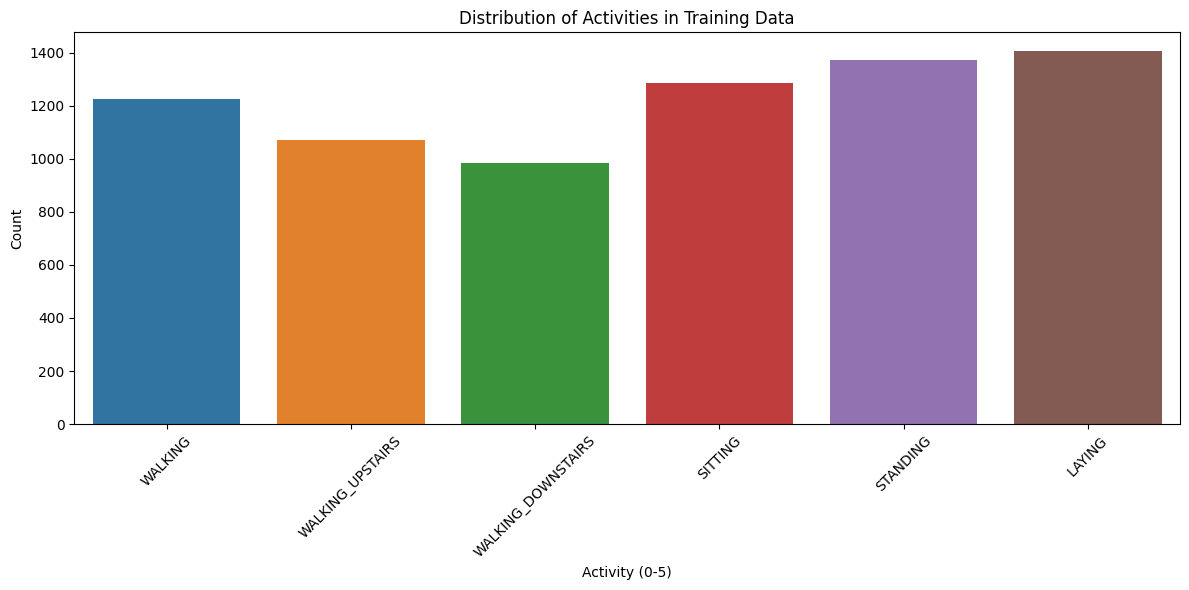

In [22]:
# Plot distribution of activities
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train)
plt.title('Distribution of Activities in Training Data')
plt.xlabel('Activity (0-5)')
plt.ylabel('Count')
plt.xticks(range(6), [activity_labels[i+1] for i in range(6)], rotation=45)
plt.tight_layout()
plt.show()


# ****Dimension 1 - Deep Learning using Raw Inertial Sensor Data****

In [20]:
# Function to create and train an LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [21]:
# Function to create and train a 1D CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [22]:
# Training an LSTM model with fewer epochs can save time.
print("Training LSTM model on raw inertial data.........")
lstm_model = create_lstm_model((X_train_inertial.shape[1], X_train_inertial.shape[2]))
lstm_history = lstm_model.fit(
    X_train_inertial, 
    y_train_onehot,
    epochs=5,  
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Training LSTM model on raw inertial data.........
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4095 - loss: 1.4144 - val_accuracy: 0.6628 - val_loss: 0.8604
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7147 - loss: 0.6870 - val_accuracy: 0.7362 - val_loss: 0.7423
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7836 - loss: 0.5187 - val_accuracy: 0.7437 - val_loss: 0.7173
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8110 - loss: 0.4588 - val_accuracy: 0.7872 - val_loss: 0.6895
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8380 - loss: 0.4008 - val_accuracy: 0.8586 - val_loss: 0.5398


In [23]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_inertial, y_test_onehot)
lstm_predictions = lstm_model.predict(X_test_inertial)
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)

print(f"\nLSTM Model Test Accuracy: {lstm_accuracy:.4f}")
print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_pred_classes, 
                          target_names=[activity_labels[i+1] for i in range(6)]))


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7921 - loss: 0.5703
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM Model Test Accuracy: 0.8456

LSTM Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.89      0.89       496
  WALKING_UPSTAIRS       0.77      0.76      0.77       471
WALKING_DOWNSTAIRS       0.74      0.83      0.78       420
           SITTING       0.79      0.84      0.82       491
          STANDING       0.87      0.79      0.83       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.85      2947
         macro avg       0.84      0.84      0.84      2947
      weighted avg       0.85      0.85      0.85      2947



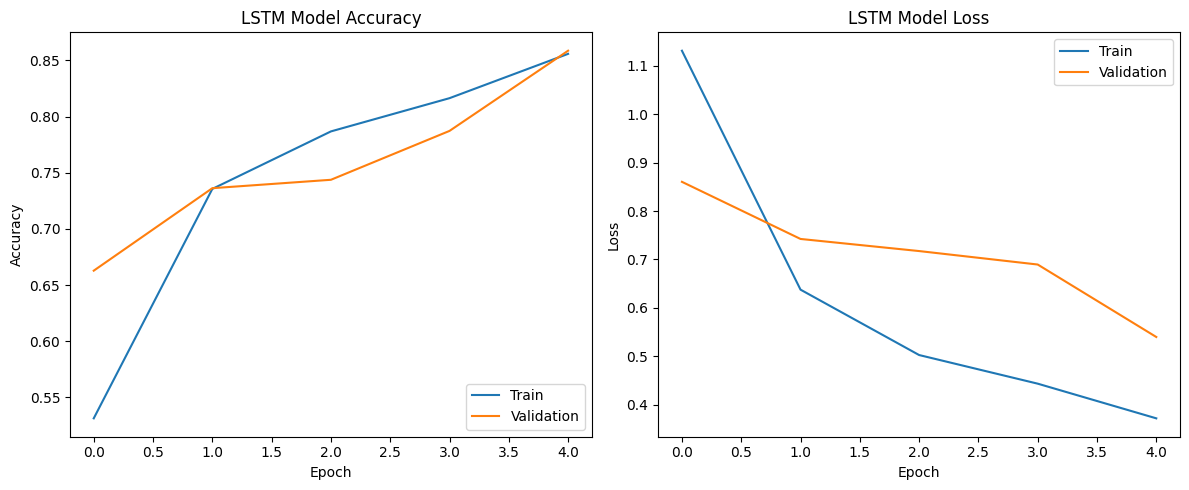

In [24]:
# Plot LSTM training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [28]:
# Training a one-dimensional CNN model with fewer epochs to save time.
print("\nTraining 1D CNN model on raw inertial data.......")
cnn_model = create_cnn_model((X_train_inertial.shape[1], X_train_inertial.shape[2]))
cnn_history = cnn_model.fit(
    X_train_inertial, 
    y_train_onehot,
    epochs=5,  # Reduced from 10 to 5 to save time
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Training 1D CNN model on raw inertial data.......
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6480 - loss: 0.8380 - val_accuracy: 0.8810 - val_loss: 0.3986
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - loss: 0.2465 - val_accuracy: 0.9007 - val_loss: 0.2804
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9454 - loss: 0.1401 - val_accuracy: 0.9130 - val_loss: 0.2515
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1157 - val_accuracy: 0.9252 - val_loss: 0.2544
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9536 - loss: 0.1003 - val_accuracy: 0.9252 - val_loss: 0.2640


In [29]:
# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_inertial, y_test_onehot)
cnn_predictions = cnn_model.predict(X_test_inertial)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

print(f"\n1D CNN Model Test Accuracy: {cnn_accuracy:.4f}")
print("\n1D CNN Classification Report:")
print(classification_report(y_test, cnn_pred_classes, 
                          target_names=[activity_labels[i+1] for i in range(6)]))


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8670 - loss: 0.4815
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

1D CNN Model Test Accuracy: 0.9094

1D CNN Classification Report:
                    precision    recall  f1-score   support

           WALKING       1.00      0.93      0.96       496
  WALKING_UPSTAIRS       0.87      0.96      0.91       471
WALKING_DOWNSTAIRS       0.93      0.99      0.96       420
           SITTING       0.83      0.82      0.82       491
          STANDING       0.85      0.83      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



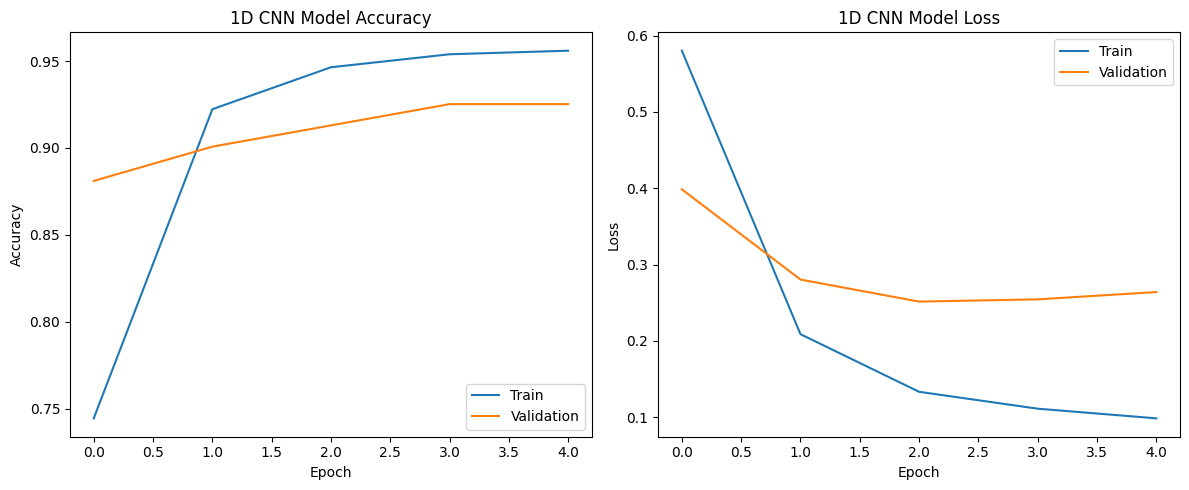

In [30]:
# Plot CNN training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('1D CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('1D CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


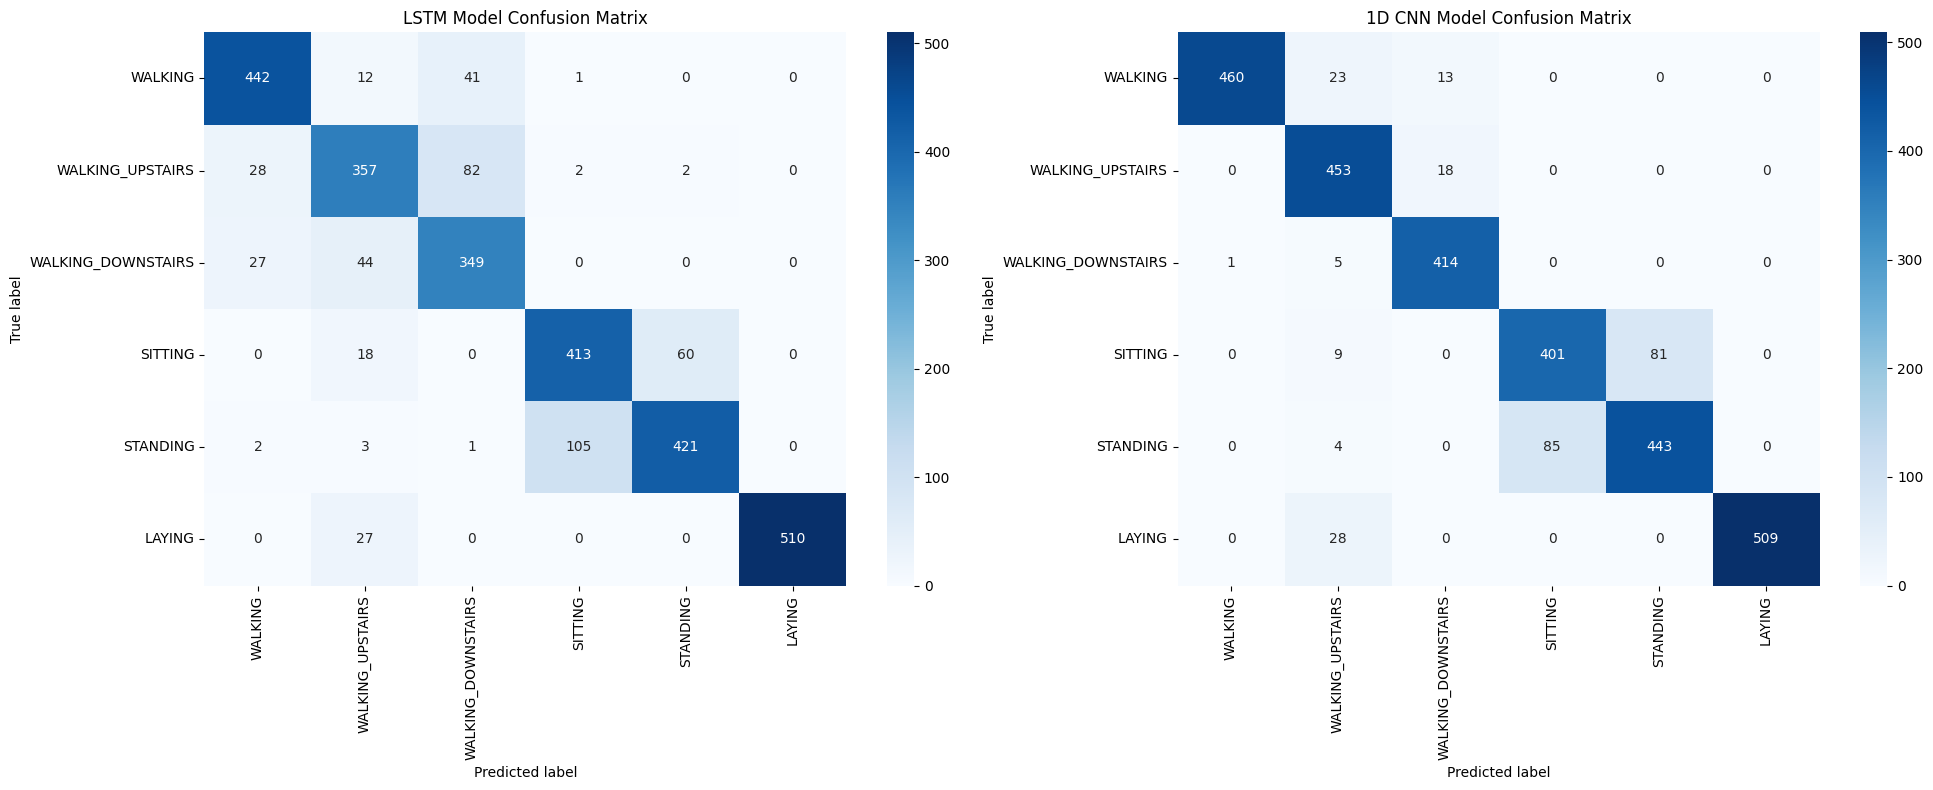

In [31]:
# Plot confusion matrices for DL models
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, lstm_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[activity_labels[i+1] for i in range(6)],
            yticklabels=[activity_labels[i+1] for i in range(6)])
plt.title('LSTM Model Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, cnn_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[activity_labels[i+1] for i in range(6)],
            yticklabels=[activity_labels[i+1] for i in range(6)])
plt.title('1D CNN Model Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.show()


# ****Dimension 2 - ML models using TSFEL-generated features from inertial data****

In [33]:
# Function to extract features from inertial signals using TSFEL - optimized version
def extract_tsfel_features(inertial_data, sample_size=None):
    """
    Extract characteristics from inertial signals using the TSFEL library.
    
    Args: inertial_data: Shape's input inertial data (samples, timesteps, and features).
        sample_size: Number of samples to process (to minimize computation)
        
    Returns: Extracted feature array.

    """
    if sample_size is not None and sample_size < len(inertial_data):
        inertial_data = inertial_data[:sample_size]
        print(f"Processing {sample_size} samples (subset of data)")
    else:
        print(f"Processing all {len(inertial_data)} samples")
    
    # Using solely statistical and spectral domains to accelerate processing.
    cfg = tsfel.get_features_by_domain(domain=['statistical', 'spectral'])
    
    # We will extract features for each signal type and axis individually.
    signal_names = [
        'body_acc_x', 'body_acc_y', 'body_acc_z',
        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
        'total_acc_x', 'total_acc_y', 'total_acc_z'
    ]
    
    all_features = []
    
    # For each sample from the dataset
    for i in range(inertial_data.shape[0]):
        if i % 100 == 0: 
            print(f"Processing sample {i}/{inertial_data.shape[0]}")
            
        sample_features = []
        
        # For each signal type (axis)
        for j in range(inertial_data.shape[2]):
            # Extract time series for this signal
            signal = inertial_data[i, :, j]
            
            # Extract features for this signal
            features = tsfel.time_series_features_extractor(cfg, signal, verbose=0)
            
            # Flatten and adding to sample features
            sample_features.extend(features.iloc[0].values)
        
        all_features.append(sample_features)
    
    return np.array(all_features)


In [34]:
# Extracting features for a smaller subset to save time
sample_size_train = 1000  
sample_size_test = 500   

In [35]:
# Extracting features 
start_time = time.time()
print(f"Extracting features for {sample_size_train} training samples...")
X_train_tsfel = extract_tsfel_features(X_train_inertial, sample_size_train)

print(f"Extracting features for {sample_size_test} test samples...")
X_test_tsfel = extract_tsfel_features(X_test_inertial, sample_size_test)
end_time = time.time()

print(f"Feature extraction completed in {end_time - start_time:.2f} seconds")
print(f"Generated TSFEL features shape - Training: {X_train_tsfel.shape}, Testing: {X_test_tsfel.shape}")


Extracting features for 1000 training samples...
Processing 1000 samples (subset of data)
Processing sample 0/1000
Processing sample 100/1000
Processing sample 200/1000
Processing sample 300/1000
Processing sample 400/1000
Processing sample 500/1000
Processing sample 600/1000
Processing sample 700/1000
Processing sample 800/1000
Processing sample 900/1000
Extracting features for 500 test samples...
Processing 500 samples (subset of data)
Processing sample 0/500
Processing sample 100/500
Processing sample 200/500
Processing sample 300/500
Processing sample 400/500
Feature extraction completed in 256.84 seconds
Generated TSFEL features shape - Training: (1000, 1278), Testing: (500, 1278)


In [36]:
# Get corresponding labels for the subset
y_train_subset = y_train[:sample_size_train]
y_test_subset = y_test[:sample_size_test]


In [37]:
# Replacing NaN values with 0
X_train_tsfel = np.nan_to_num(X_train_tsfel)
X_test_tsfel = np.nan_to_num(X_test_tsfel)


In [38]:
# Standardizing the features
scaler = StandardScaler()
X_train_tsfel_scaled = scaler.fit_transform(X_train_tsfel)
X_test_tsfel_scaled = scaler.transform(X_test_tsfel)


In [39]:
# Using the same subset size for consistency
X_train_features_subset = X_train_features[:sample_size_train]
X_test_features_subset = X_test_features[:sample_size_test]

scaler_orig = StandardScaler()
X_train_features_scaled = scaler_orig.fit_transform(X_train_features_subset)
X_test_features_scaled = scaler_orig.transform(X_test_features_subset)


In [40]:
# Creating arrays to store results for comparison
ml_results = {
    'Model': [],
    'Features': [],
    'Accuracy': [],
    'Training Time': []
}

In [41]:
# Function to train and evaluate ML models
def train_evaluate_ml_model(model, X_train, X_test, y_train, y_test, model_name, feature_type):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    ml_results['Model'].append(model_name)
    ml_results['Features'].append(feature_type)
    ml_results['Accuracy'].append(accuracy)
    ml_results['Training Time'].append(training_time)
    
    # Print results
    print(f"{model_name} with {feature_type} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f}s")
    
    # Print classification report
    print(f"\nClassification Report ({model_name} with {feature_type}):")
    print(classification_report(y_test, y_pred, 
                              target_names=[activity_labels[i+1] for i in range(6)]))
    
    return y_pred


In [42]:
# Random Forest on TSFEL features
print("\nTraining Random Forest with TSFEL features...")
rf_tsfel = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_tsfel_pred = train_evaluate_ml_model(
    rf_tsfel, X_train_tsfel_scaled, X_test_tsfel_scaled, y_train_subset, y_test_subset, 
    "Random Forest", "TSFEL")



Training Random Forest with TSFEL features...
Random Forest with TSFEL - Accuracy: 0.8820, Training Time: 0.55s

Classification Report (Random Forest with TSFEL):
                    precision    recall  f1-score   support

           WALKING       0.99      1.00      0.99        90
  WALKING_UPSTAIRS       0.93      0.99      0.96        76
WALKING_DOWNSTAIRS       0.98      0.90      0.94        70
           SITTING       0.70      0.58      0.63        76
          STANDING       0.74      0.83      0.78       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.88       500
         macro avg       0.89      0.88      0.88       500
      weighted avg       0.88      0.88      0.88       500



In [42]:
# SVM on TSFEL features
print("\nTraining SVM with TSFEL features.......")
svm_tsfel = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_tsfel_pred = train_evaluate_ml_model(
    svm_tsfel, X_train_tsfel_scaled, X_test_tsfel_scaled, y_train_subset, y_test_subset, 
    "SVM", "TSFEL")



Training SVM with TSFEL features.......
SVM with TSFEL - Accuracy: 0.9040, Training Time: 0.23s

Classification Report (SVM with TSFEL):
                    precision    recall  f1-score   support

           WALKING       0.99      0.99      0.99        90
  WALKING_UPSTAIRS       1.00      0.67      0.80        76
WALKING_DOWNSTAIRS       0.74      1.00      0.85        70
           SITTING       0.88      0.83      0.85        76
          STANDING       0.89      0.92      0.90       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.90       500
         macro avg       0.91      0.90      0.90       500
      weighted avg       0.92      0.90      0.90       500



In [43]:
# Logistic Regression on TSFEL features
print("\nTraining Logistic Regression with TSFEL features......")
lr_tsfel = LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs', multi_class='multinomial', random_state=42)
lr_tsfel_pred = train_evaluate_ml_model(
    lr_tsfel, X_train_tsfel_scaled, X_test_tsfel_scaled, y_train_subset, y_test_subset, 
    "Logistic Regression", "TSFEL")



Training Logistic Regression with TSFEL features......
Logistic Regression with TSFEL - Accuracy: 0.9360, Training Time: 0.62s

Classification Report (Logistic Regression with TSFEL):
                    precision    recall  f1-score   support

           WALKING       0.97      1.00      0.98        90
  WALKING_UPSTAIRS       1.00      0.93      0.97        76
WALKING_DOWNSTAIRS       0.97      1.00      0.99        70
           SITTING       0.86      0.78      0.81        76
          STANDING       0.85      0.91      0.88       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.94       500
         macro avg       0.94      0.94      0.94       500
      weighted avg       0.94      0.94      0.94       500



# ****Dimension 3 ML Models with Pre-extracted Features from Authors****

In [44]:
# Random Forest on original features
print("\nTraining Random Forest with original features.......")
rf_orig = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_orig_pred = train_evaluate_ml_model(
    rf_orig, X_train_features_scaled, X_test_features_scaled, y_train_subset, y_test_subset, 
    "Random Forest", "Original")



Training Random Forest with original features.......
Random Forest with Original - Accuracy: 0.8900, Training Time: 0.46s

Classification Report (Random Forest with Original):
                    precision    recall  f1-score   support

           WALKING       0.90      0.97      0.93        90
  WALKING_UPSTAIRS       0.92      0.91      0.91        76
WALKING_DOWNSTAIRS       0.97      0.89      0.93        70
           SITTING       0.90      0.58      0.70        76
          STANDING       0.77      0.95      0.85       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.89       500
         macro avg       0.91      0.88      0.89       500
      weighted avg       0.90      0.89      0.89       500



In [45]:
# SVM on original features
print("\nTraining SVM with original features......")
svm_orig = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_orig_pred = train_evaluate_ml_model(
    svm_orig, X_train_features_scaled, X_test_features_scaled, y_train_subset, y_test_subset, 
    "SVM", "Original")



Training SVM with original features......
SVM with Original - Accuracy: 0.8900, Training Time: 0.09s

Classification Report (SVM with Original):
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00        90
  WALKING_UPSTAIRS       1.00      0.64      0.78        76
WALKING_DOWNSTAIRS       0.72      1.00      0.84        70
           SITTING       0.98      0.64      0.78        76
          STANDING       0.80      0.99      0.89       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.89       500
         macro avg       0.92      0.88      0.88       500
      weighted avg       0.91      0.89      0.89       500



In [46]:
# Logistic Regression on original features
print("\nTraining Logistic Regression with original features......")
lr_orig = LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs', multi_class='multinomial', random_state=42)
lr_orig_pred = train_evaluate_ml_model(
    lr_orig, X_train_features_scaled, X_test_features_scaled, y_train_subset, y_test_subset, 
    "Logistic Regression", "Original")



Training Logistic Regression with original features......
Logistic Regression with Original - Accuracy: 0.8980, Training Time: 0.24s

Classification Report (Logistic Regression with Original):
                    precision    recall  f1-score   support

           WALKING       0.98      1.00      0.99        90
  WALKING_UPSTAIRS       1.00      0.79      0.88        76
WALKING_DOWNSTAIRS       0.82      0.99      0.90        70
           SITTING       0.98      0.57      0.72        76
          STANDING       0.77      0.99      0.87       110
            LAYING       1.00      1.00      1.00        78

          accuracy                           0.90       500
         macro avg       0.92      0.89      0.89       500
      weighted avg       0.92      0.90      0.89       500



In [47]:
# Create a comparison table
results_df = pd.DataFrame(ml_results)
print("\nML Model Comparison:")
print(results_df)



ML Model Comparison:
                 Model  Features  Accuracy  Training Time
0        Random Forest     TSFEL     0.882       0.545341
1  Logistic Regression     TSFEL     0.936       0.618215
2        Random Forest  Original     0.890       0.459728
3                  SVM  Original     0.890       0.093951
4  Logistic Regression  Original     0.898       0.244375


In [48]:
# Plot results
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

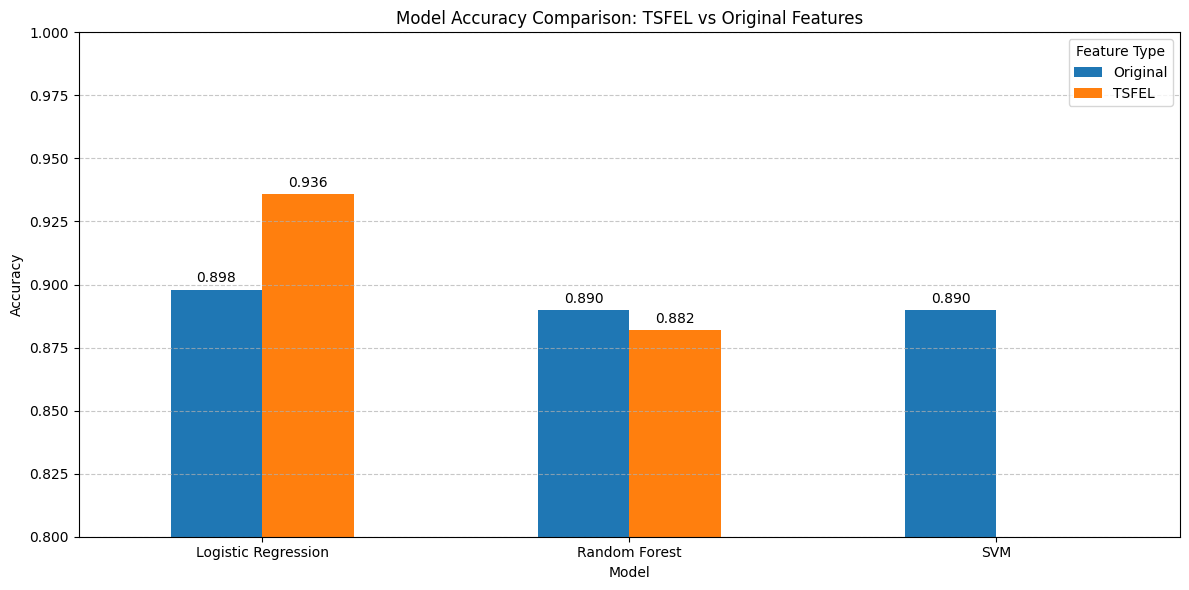

In [58]:
# Group by features and model
grouped_results = results_df.pivot(index='Model', columns='Features', values='Accuracy')

# Plot accuracy comparison
ax = grouped_results.plot(kind='bar', figsize=(12, 6))
plt.title('Model Accuracy Comparison: TSFEL vs Original Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.legend(title='Feature Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()


<Figure size 2000x800 with 0 Axes>

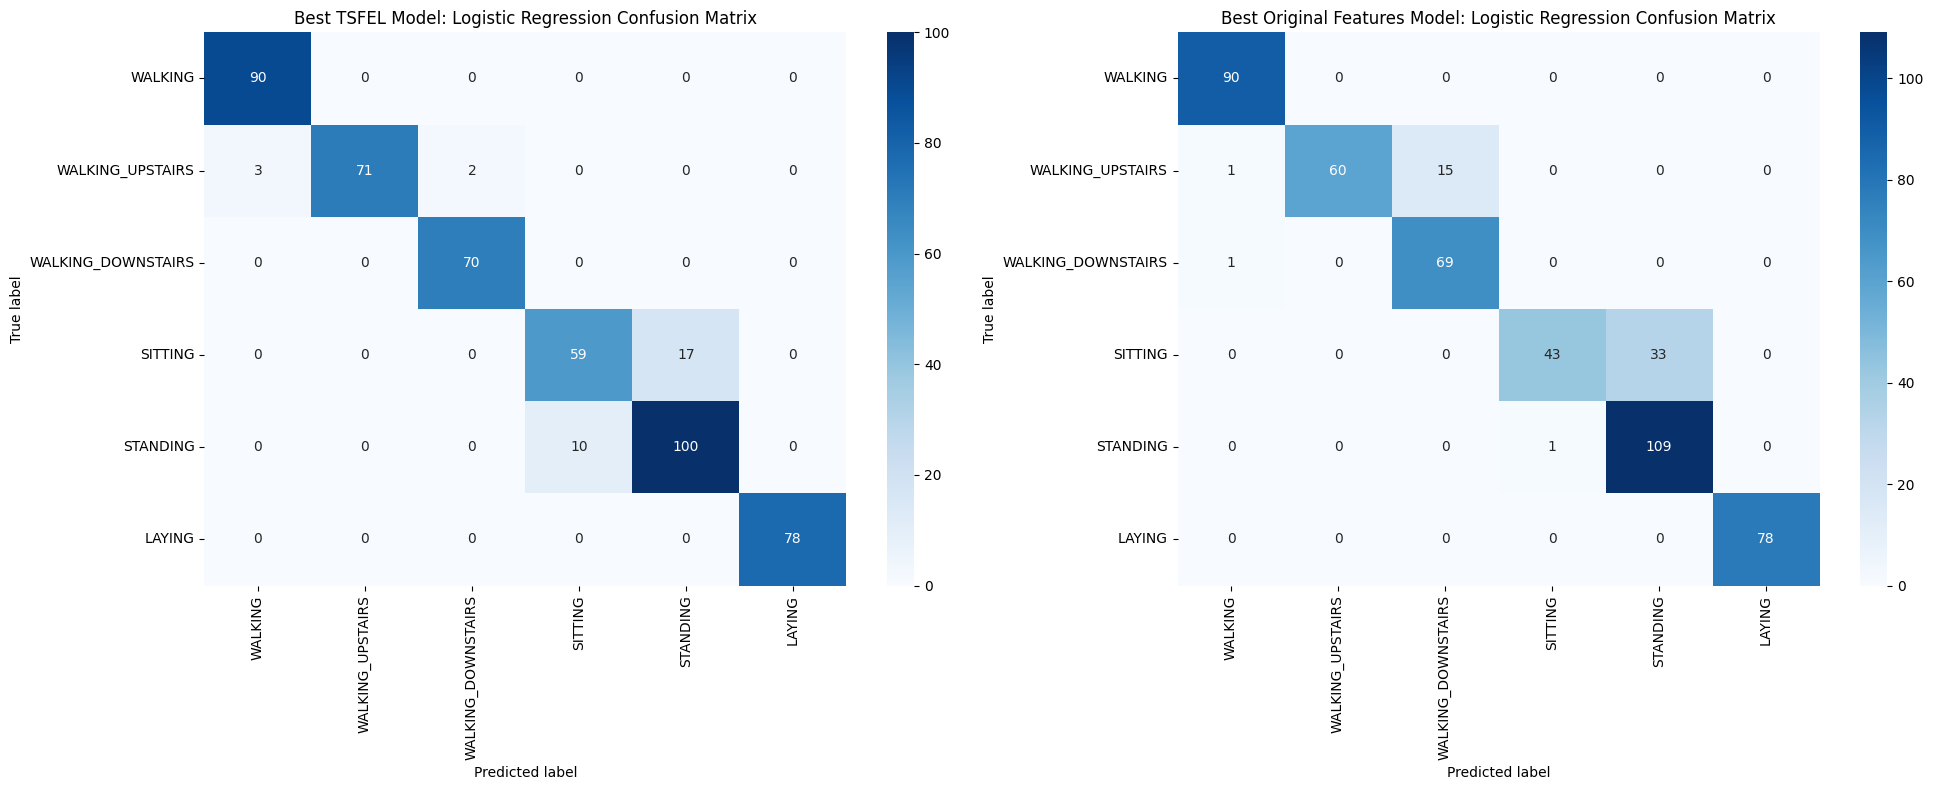

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(20, 8))
# Identify best models
tsfel_models_accuracy = results_df[results_df['Features'] == 'TSFEL']['Accuracy']
orig_models_accuracy = results_df[results_df['Features'] == 'Original']['Accuracy']
best_tsfel_model_idx = tsfel_models_accuracy.idxmax()
best_orig_model_idx = orig_models_accuracy.idxmax()
best_tsfel_model = results_df.iloc[best_tsfel_model_idx]['Model']
best_orig_model = results_df.iloc[best_orig_model_idx]['Model']

# Get predictions for best models
if best_tsfel_model == "Random Forest":
    best_tsfel_pred = rf_tsfel_pred
elif best_tsfel_model == "SVM":
    best_tsfel_pred = svm_tsfel_pred
else:
    best_tsfel_pred = lr_tsfel_pred
    
if best_orig_model == "Random Forest":
    best_orig_pred = rf_orig_pred
elif best_orig_model == "SVM":
    best_orig_pred = svm_orig_pred
else:
    best_orig_pred = lr_orig_pred

plt.tight_layout()
plt.show()

# Plot confusion matrices
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_subset, best_tsfel_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[activity_labels[i+1] for i in range(6)],
            yticklabels=[activity_labels[i+1] for i in range(6)])
plt.title(f'Best TSFEL Model: {best_tsfel_model} Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_subset, best_orig_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[activity_labels[i+1] for i in range(6)],
            yticklabels=[activity_labels[i+1] for i in range(6)])
plt.title(f'Best Original Features Model: {best_orig_model} Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.show()

# ****Dimension 4 Summary and Conclusions****

In [61]:
# Combine all results for comparison
all_models = {
    'Model': ['LSTM', '1D CNN'] + ml_results['Model'],
    'Features': ['Raw Inertial', 'Raw Inertial'] + ml_results['Features'],
    'Accuracy': [lstm_accuracy, cnn_accuracy] + ml_results['Accuracy']
}

all_results_df = pd.DataFrame(all_models)
print("\nAll Models Comparison:")
print(all_results_df)



All Models Comparison:
                 Model      Features  Accuracy
0                 LSTM  Raw Inertial  0.845606
1               1D CNN  Raw Inertial  0.909399
2        Random Forest         TSFEL  0.882000
3  Logistic Regression         TSFEL  0.936000
4        Random Forest      Original  0.890000
5                  SVM      Original  0.890000
6  Logistic Regression      Original  0.898000


In [62]:
# Create a summary plot
plt.figure(figsize=(14, 8))


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

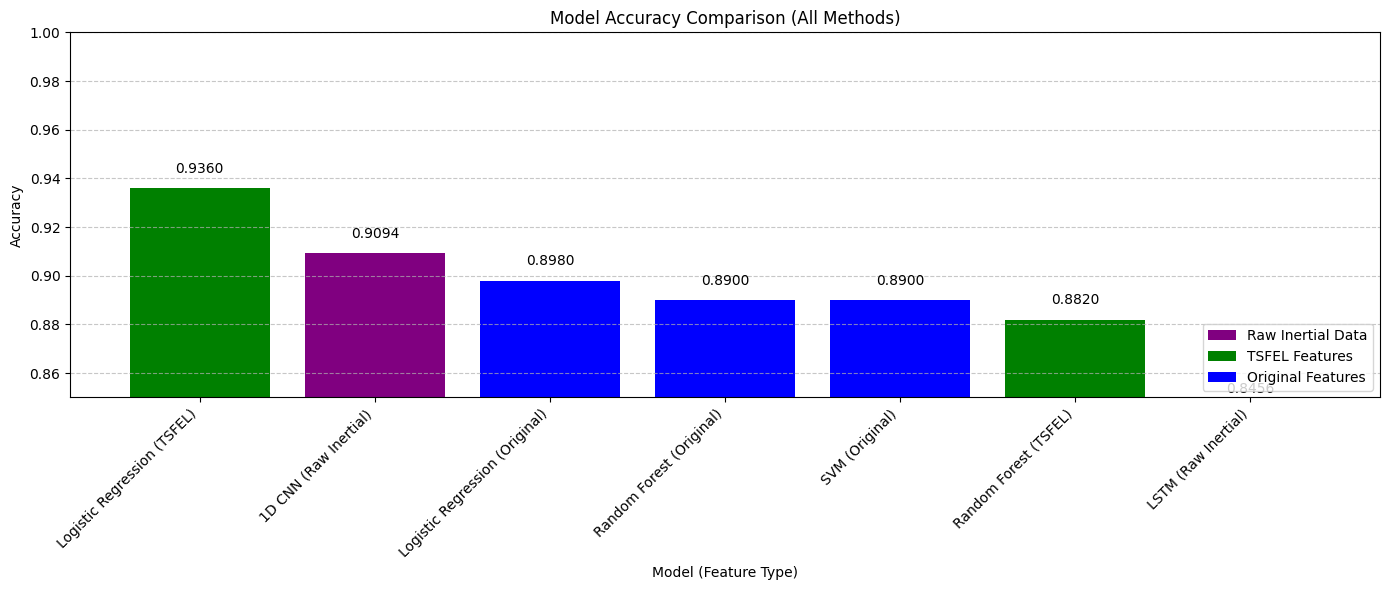

In [66]:
# Create a summary plot
plt.figure(figsize=(14, 8))

# Extract model types and accuracies
model_features = all_results_df['Model'] + ' (' + all_results_df['Features'] + ')'
accuracies = all_results_df['Accuracy']

# Sort by accuracy
sorted_indices = np.argsort(accuracies)[::-1]
sorted_model_features = [model_features[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create bar colors based on feature type
colors = []
for i in sorted_indices:
    if all_results_df['Features'][i] == 'Raw Inertial':
        colors.append('purple')
    elif all_results_df['Features'][i] == 'TSFEL':
        colors.append('green')
    else:
        colors.append('blue')

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(sorted_model_features, sorted_accuracies, color=colors)
plt.title('Model Accuracy Comparison (All Methods)')
plt.ylabel('Accuracy')
plt.xlabel('Model (Feature Type)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.85, 1.0)  # Adjust as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.005,
        f'{height:.4f}',
        ha='center', va='bottom',
        rotation=0
    )
# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', label='Raw Inertial Data'),
    Patch(facecolor='green', label='TSFEL Features'),
    Patch(facecolor='blue', label='Original Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

